In [1]:
import os
import sys
import numpy as np
from tqdm import tqdm
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


sns.set(context="talk", style="ticks", palette="husl", color_codes=True)

from lvmdrp.core import image
from lvmdrp.functions import imageMethod
from lvmdrp.functions import rssMethod

In [2]:
TELESCOPES = [1, 2, 3]
CHANNELS = ["b", "r", "z"]

BIAS_IDS = [0,1,2,3,4,17,18,19]
DARKS_IDS = [24,25,26,27,28,29,30,31,32,33]
FLAT_IDS = [5,6,22,23]
LAMP_IDS = [7,8,20,21]
SCIE_IDS = [9,10,11,12,13,14,15,16]


# simulation path
sim_path = os.path.join("_data-sim/2d")
# output path
out_path = os.path.join("_data-sim/outs")


In [20]:
from scipy.stats import describe


# compute gain
# - read flats
# - trim os region
# - split in science regions
# - compute statistics for each region

flat_in_path = os.path.join(sim_path, "darks")
flat_ou_path = os.path.join(out_path, "darks")

N_FLATS = len(DARKS_IDS) * 3 * 3
mean, sdev = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
skew, kurt = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
fmin, fmax = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
metadata = []
for j, (flat_id, tel, channel) in enumerate(it.product(DARKS_IDS, TELESCOPES, CHANNELS)):
    frame_label = f"sdR-{channel}{tel}-{flat_id:08}"
    frame_in_path = os.path.join(flat_in_path, f"{frame_label}.fit.gz")
    frame_ou_path = os.path.join(flat_ou_path, f"{frame_label}.pre.fit")

    if not os.path.isfile(frame_in_path):
        metadata.append({"index": j, "filename": frame_label, "channel": channel, "telescope": tel, "exptime": np.nan})
        continue

    flat = image.loadImage(frame_in_path)

    metadata.append({"index": j, "filename": frame_label, "channel": channel, "telescope": tel, "exptime": flat._header["EXPTIME"]})

    cd, ab = flat.split(2, axis="Y")
    (a, b), (c, d) = ab.split(2, axis="X"), cd.split(2, axis="X")
    # reflect b and d amplifiers to have the overscan regions in the last columns
    b.orientImage("X")
    d.orientImage("X")
    amps = [a, b, c, d]
    ny, nx = a._data.shape
    for i, (amp_name, amp) in enumerate(zip(mean.keys(), amps)):
        res = (amps[i]._data-np.median(amps[i]._data)).ravel()
        mask = res <= 0
        res = res[mask]
        res_ref = np.asarray(res.tolist()+(-res).tolist())
        # return original X axis orientation
        if i in [1,3]: amps[i].orientImage("X")

        # MASK POTENTIALLY BAD PIXELS
        # mask out pixels affected by vigneting and other border pixels (stay near the center of the CCD)
        # if i in [0,1]:
        #     data_cut = amps[i]._data[ny//10:ny-ny//(100//40), nx//10:nx-nx//10]
        # elif i in [2,3]:
        #     data_cut = amps[i]._data[ny-ny//(100//40):ny-ny//10, nx//10:nx-nx//10]
        # USE WHOLE FRAME
        data_cut = amps[i]._data

        stats = describe(data_cut, axis=None)
        mean[amp_name][j] = stats.mean
        sdev[amp_name][j] = np.std(res_ref) #np.sqrt(stats.variance)
        kurt[amp_name][j] = stats.kurtosis
        skew[amp_name][j] = stats.skewness
        fmin[amp_name][j], fmax[amp_name][j] = stats.minmax

number of frames: 10
gain = 2.6183522915569752


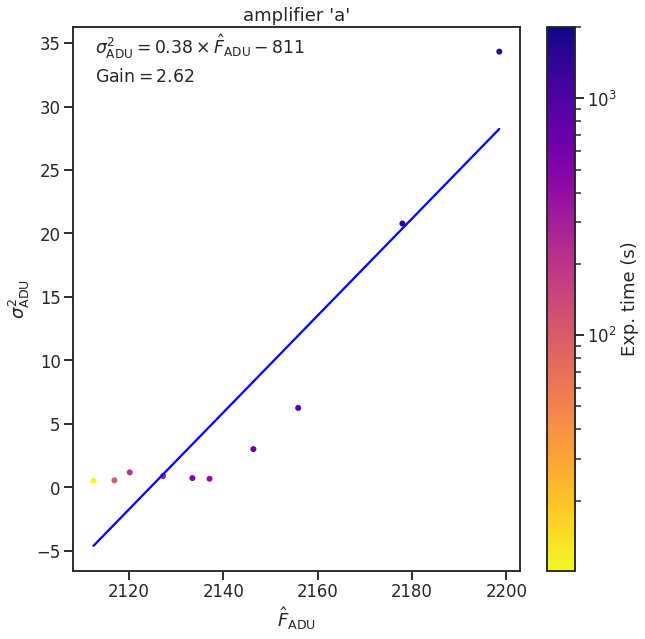

In [37]:
from scipy.optimize import least_squares


def model(par, x):
    m, b = par
    return m*x + b

def residuals(par, x, y):
    y_mod = model(par, x)
    return y_mod - y

fig, ax = plt.subplots(figsize=(10,10))
# ax.set_xscale("log")
# ax.set_yscale("log")

md = pd.DataFrame(metadata).set_index("index")

for amp in "a":
    x, y = mean[amp], sdev[amp]**2
    z = md.exptime
    mask = np.ones_like(z, dtype=bool)
    mask &= np.logical_not(np.isnan(z))
    mask &= md.telescope == 2
    mask &= md.channel == "b"

    # mask &= (x>=2500)&(x<=40000)
    # mask &= x<=600
    # mask &= np.abs(skew[amp])<=0.5
    # mask &= (y>=10**2)&(y<=300**2)
    # mask &= (z>5)&(z<=100)
    print(f"number of frames: {mask.sum()}")
    if mask.sum() == 0:
        continue
    x, y, z = x[mask], y[mask], z[mask]
    res = least_squares(fun=residuals, x0=(1,0), args=(x, y))

    # ax.axvline(2**16, ls="--", color="k")
    # ax.axvspan(2500, 40000, color="0.7", alpha=0.5, lw=0)
    # ax.axhspan(10**2, 300**2, color="0.7", alpha=0.5)

    xs = np.linspace(x.min(), x.max(), 100)
    ys = model(res.x, xs)
    sc = ax.scatter(x, y, c=z, s=20, cmap="plasma_r", norm=mpl.colors.LogNorm())
    cb = plt.colorbar(sc)
    ax.plot(xs, ys, "-b")
    ax.set_title(f"amplifier '{amp}'")
    ax.text(
        0.05, 0.95,
        f"$\sigma_\mathrm{{ADU}}^2 = {res.x[0]:.2f} \\times \hat{{F}}_\mathrm{{ADU}} {'+' if res.x[1]>=0 else '-'} {np.abs(res.x[1]):.0f}$",
        size="xx-large", transform=ax.transAxes
    )
    ax.text(0.05, 0.90, f"Gain$={1/res.x[0]:.2f}$", size="xx-large", transform=ax.transAxes)
    print(f"gain = {1/res.x[0]}")

    ax.set_ylabel(r"$\sigma_\mathrm{ADU}^2$")
    ax.set_xlabel(r"${\hat{F}_\mathrm{ADU}}$")
    cb.set_label("Exp. time (s)")

In [ ]:
# reduce bias
# reduce flats
# reduce continuum
# reduce arcs